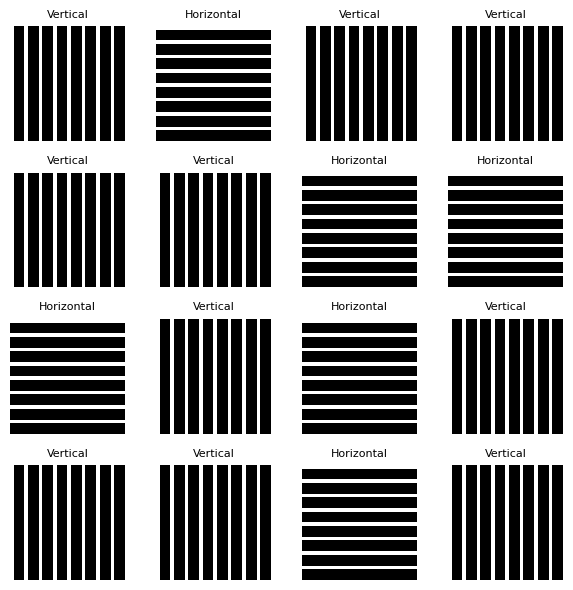

In [1]:
# visualize_bars_dataset.py
import numpy as np
import matplotlib.pyplot as plt

def make_bars_image(size=32, orientation="vertical", spacing=4):
    img = np.zeros((size, size), dtype=np.float32)
    if orientation == "vertical":
        img[:, ::spacing] = 1.0   # stripes along columns
    else:
        img[::spacing, :] = 1.0   # stripes along rows
    return img

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for ax in axes.ravel():
    if np.random.rand() < 0.5:
        img = make_bars_image(32, "vertical")
        label = "Vertical"
    else:
        img = make_bars_image(32, "horizontal")
        label = "Horizontal"
    ax.imshow(img, cmap="gray", vmin=0, vmax=1)
    ax.set_title(label, fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()



In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

class BarsDataset(Dataset):
    def __init__(self, n=1000, size=32):
        self.x = []
        self.y = []
        for _ in range(n):
            img = np.zeros((size, size), np.float32)
            if np.random.rand() < 0.5:
                # vertical bars
                img[:, ::4] = 1.0; label = 0
            else:
                # horizontal bars
                img[::4, :] = 1.0; label = 1
            self.x.append(img)
            self.y.append(label)
        self.x = torch.tensor(np.stack(self.x))[:, None, :, :]  # (N,1,H,W)
        self.y = torch.tensor(self.y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.x[i], self.y[i]

class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8,16,3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16*8*8, 2)
        )
    def forward(self, x): return self.net(x)
    
ds = BarsDataset(n=2000, size=32)
dl = DataLoader(ds, batch_size=64, shuffle=True)

model = TinyCNN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    total, correct, running = 0, 0, 0.0
    for xb, yb in dl:
        logits = model(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()

        running += float(loss)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item(); total += yb.size(0)
    print(f"epoch {epoch+1} loss {running/len(dl):.3f} acc {correct/total:.3f}")
    

epoch 1 loss 0.283 acc 0.889
epoch 2 loss 0.002 acc 1.000
epoch 3 loss 0.000 acc 1.000
epoch 4 loss 0.000 acc 1.000
epoch 5 loss 0.000 acc 1.000


# Adding noise

In [2]:
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# --- Dataset ---
class NoisyBarsDataset(Dataset):
    def __init__(self, n=1000, size=32, spacing=4, noise_std=0.1):
        self.x, self.y = [], []
        for _ in range(n):
            img = np.zeros((size, size), np.float32)
            if np.random.rand() < 0.5:
                img[:, ::spacing] = 1.0; label = 0
            else:
                img[::spacing, :] = 1.0; label = 1
            img += np.random.normal(0, noise_std, img.shape)
            img = np.clip(img, 0, 1)
            self.x.append(img)
            self.y.append(label)
        self.x = torch.tensor(np.stack(self.x))[:, None, :, :]
        self.y = torch.tensor(self.y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.x[i], self.y[i]



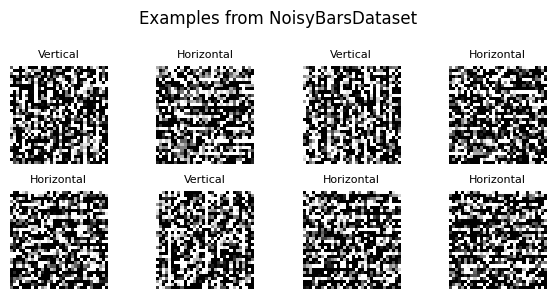

In [ ]:
# --- Visualize some sample images ---
import matplotlib.pyplot as plt

# create a small sample dataset for visualization
sample_ds = NoisyBarsDataset(n=8, size=32, noise_std=1) # change this

fig, axes = plt.subplots(2, 4, figsize=(6,3))
for i, ax in enumerate(axes.ravel()):
    img, label = sample_ds[i]
    ax.imshow(img[0], cmap="gray", vmin=0, vmax=1)
    ax.set_title("Vertical" if label == 0 else "Horizontal", fontsize=8)
    ax.axis("off")

plt.suptitle("Examples from NoisyBarsDataset", fontsize=12)
plt.tight_layout()
plt.show()


In [4]:
# --- Model ---
class NoisyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16*8*8, 2)
        )
    def forward(self, x): return self.net(x)

# --- Training ---
train_ds = NoisyBarsDataset(1000, noise_std=1)
test_ds  = NoisyBarsDataset(300, noise_std=1)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=64)

model = NoisyCNN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    total, correct, running = 0, 0, 0.0
    for xb, yb in train_dl:
        logits = model(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        running += float(loss)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item(); total += yb.size(0)
    print(f"Epoch {epoch+1} Train Acc: {correct/total:.3f}, Loss: {running/len(train_dl):.3f}")

# --- Test performance ---
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_dl:
        pred = model(xb).argmax(1)
        correct += (pred == yb).sum().item(); total += yb.size(0)
print(f"Test Accuracy: {correct/total:.3f}")

C:\Users\miche\AppData\Local\Temp\ipykernel_32984\2199694428.py:32: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  running += float(loss)


Epoch 1 Train Acc: 0.516, Loss: 0.691
Epoch 2 Train Acc: 0.665, Loss: 0.632
Epoch 3 Train Acc: 0.958, Loss: 0.496
Epoch 4 Train Acc: 1.000, Loss: 0.269
Epoch 5 Train Acc: 1.000, Loss: 0.098
Test Accuracy: 1.000


# Different shapes

In [ ]:
import numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import matplotlib.pyplot as plt

# --- Shape dataset ---
class ShapesDataset(Dataset):
    def __init__(self, n=1000, size=32):
        self.x, self.y = [], []
        yy, xx = np.mgrid[:size, :size]
        for _ in range(n):
            img = np.zeros((size, size), np.float32)
            if np.random.rand() < 0.5:
                mask = (xx - size/2)**2 + (yy - size/2)**2 < (size/4)**2
                label = 0  # circle
            else:
                mask = (np.abs(xx - size/2) < size/4) & (np.abs(yy - size/2) < size/4)
                label = 1  # square
            img[mask] = 1.0
            img += np.random.normal(0, 0.05, img.shape)
            img = np.clip(img, 0, 1)
            self.x.append(img)
            self.y.append(label)
        self.x = torch.tensor(np.stack(self.x))[:, None, :, :]
        self.y = torch.tensor(self.y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.x[i], self.y[i]

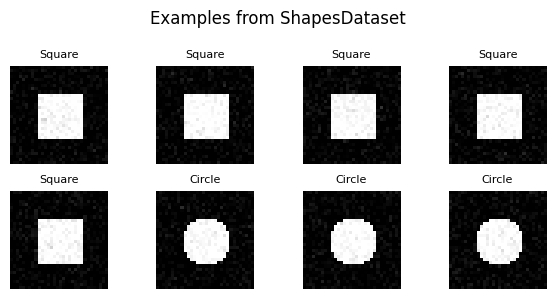

In [7]:
# --- Visualize some shape samples ---
import matplotlib.pyplot as plt

sample_ds = ShapesDataset(n=8, size=32)

fig, axes = plt.subplots(2, 4, figsize=(6,3))
for i, ax in enumerate(axes.ravel()):
    img, label = sample_ds[i]
    ax.imshow(img[0], cmap="gray", vmin=0, vmax=1)
    ax.set_title("Circle" if label == 0 else "Square", fontsize=8)
    ax.axis("off")

plt.suptitle("Examples from ShapesDataset", fontsize=12)
plt.tight_layout()
plt.show()


In [8]:
# --- CNN model ---
class ShapeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16*8*8, 2)
        )
    def forward(self, x): return self.net(x)

# --- Train ---
train_ds = ShapesDataset(1000)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
model = ShapeCNN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    correct, total, running = 0, 0, 0
    for xb, yb in train_dl:
        logits = model(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        running += float(loss)
        correct += (logits.argmax(1) == yb).sum().item()
        total += yb.size(0)
    print(f"Epoch {epoch+1} loss {running/len(train_dl):.3f} acc {correct/total:.3f}")


Epoch 1 loss 0.637 acc 0.893
Epoch 2 loss 0.480 acc 1.000
Epoch 3 loss 0.270 acc 1.000
Epoch 4 loss 0.107 acc 1.000
Epoch 5 loss 0.037 acc 1.000


# Shapes GUI basic

In [ ]:
import tkinter as tk
from PIL import ImageGrab, Image
import numpy as np, torch
import torch.nn.functional as F

# --- assume trained ShapeCNN model ---
model.eval()

# --- GUI setup ---
SIZE = 280  # canvas size (bigger than 32x32)
scale = SIZE // 32  # for resizing later
root = tk.Tk()
root.title("AI Shape Classifier")

canvas = tk.Canvas(root, width=SIZE, height=SIZE, bg="black")
canvas.pack()

def draw(event):
    x, y = event.x, event.y
    r = 8
    canvas.create_oval(x-r, y-r, x+r, y+r, fill="white", outline="white")

canvas.bind("<B1-Motion>", draw)

label = tk.Label(root, text="Draw a shape (circle or square)!", font=("Arial", 14))
label.pack(pady=10)

def predict():
    x0 = root.winfo_rootx() + canvas.winfo_x()
    y0 = root.winfo_rooty() + canvas.winfo_y()
    x1 = x0 + SIZE
    y1 = y0 + SIZE
    img = ImageGrab.grab().crop((x0, y0, x1, y1)).convert("L").resize((32,32))
    arr = np.array(img, dtype=np.float32)/255.0
    arr = torch.tensor(arr)[None, None, :, :]
    with torch.no_grad():
        probs = F.softmax(model(arr), dim=1)[0]
        pred = model(arr).argmax(1).item()
        conf = probs[pred].item()
    name = "Circle" if pred==0 else "Square"
    label.config(text=f"Prediction: {name} ({conf*100:.1f}% confidence)")

def clear():
    canvas.delete("all")
    label.config(text="Draw a shape (circle or square)!")

tk.Button(root, text="Predict", command=predict, font=("Arial", 12)).pack(side="left", padx=10)
tk.Button(root, text="Clear", command=clear, font=("Arial", 12)).pack(side="right", padx=10)
root.mainloop()


# GUI select CNN

In [ ]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import numpy as np

# ---------- DEFINE MODELS ----------

# Loading different models
MODELS = {
    "Bars": TinyCNN(),
    "NoisyBars": NoisyCNN(),
    "Shapes": ShapeCNN()
}

# Pretend models are pre-trained
for m in MODELS.values():
    for p in m.parameters():
        torch.nn.init.normal_(p, mean=0, std=0.02)
    m.eval()

# ---------- GUI APP ----------

class DrawApp:
    def __init__(self, root):
        self.root = root
        self.root.title("AI Classifier Demo")
        self.root.geometry("420x550")
        self.root.resizable(False, False)
        self.root.configure(padx=10, pady=10)

        style = ttk.Style()
        style.theme_use("clam")
        style.configure("TButton", padding=6, font=("Segoe UI", 10))
        style.configure("TLabel", font=("Segoe UI", 11))

        # Model selection
        ttk.Label(root, text="Select Model:").grid(row=0, column=0, sticky="w")
        self.model_var = tk.StringVar(value="Bars")
        self.model_select = ttk.Combobox(root, textvariable=self.model_var, values=list(MODELS.keys()), state="readonly", width=15)
        self.model_select.grid(row=0, column=1, columnspan=2, pady=5, sticky="ew")
        self.model_select.bind("<<ComboboxSelected>>", self.switch_model)

        # Canvas setup
        self.canvas_size = 256
        self.canvas = tk.Canvas(root, width=self.canvas_size, height=self.canvas_size,
                                bg="white", relief="ridge", bd=2)
        self.canvas.grid(row=1, column=0, columnspan=3, pady=10)
        self.canvas.bind("<B1-Motion>", self.draw)

        # Image buffer
        self.image = Image.new("L", (self.canvas_size, self.canvas_size), color=255)
        self.draw_pil = ImageDraw.Draw(self.image)

        # Buttons
        ttk.Button(root, text="Predict", command=self.predict).grid(row=2, column=0, padx=5, pady=5, sticky="ew")
        ttk.Button(root, text="Clear", command=self.clear).grid(row=2, column=1, padx=5, pady=5, sticky="ew")
        ttk.Button(root, text="Exit", command=root.quit).grid(row=2, column=2, padx=5, pady=5, sticky="ew")

        # Result label
        self.result_label = ttk.Label(root, text="Draw and click Predict.", anchor="center", background="#f0f0f0")
        self.result_label.grid(row=3, column=0, columnspan=3, pady=10, sticky="ew")

        # Current model
        self.model = MODELS[self.model_var.get()]

        # Configure resizing
        for i in range(3):
            root.grid_columnconfigure(i, weight=1)

    # ---------- DRAWING ----------
    def draw(self, event):
        x, y = event.x, event.y
        r = 4
        self.canvas.create_oval(x-r, y-r, x+r, y+r, fill="black", outline="black")
        self.draw_pil.ellipse([x-r, y-r, x+r, y+r], fill=0)

    def clear(self):
        self.canvas.delete("all")
        self.image = Image.new("L", (self.canvas_size, self.canvas_size), color=255)
        self.draw_pil = ImageDraw.Draw(self.image)
        self.result_label.config(text="Canvas cleared. Draw again!")

    # ---------- MODEL SWITCH ----------
    def switch_model(self, event=None):
        selected = self.model_var.get()
        self.model = MODELS[selected]
        self.result_label.config(text=f"Switched to {selected} model. Draw and click Predict.")

    # ---------- PREDICTION ----------
    def predict(self):
        img_small = self.image.resize((32, 32))
        img_tensor = torch.tensor(np.array(img_small, dtype=np.float32) / 255.0)
        img_tensor = 1 - img_tensor  # invert colors
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # (1,1,32,32)

        with torch.no_grad():
            logits = self.model(img_tensor)
            probs = torch.softmax(logits, dim=1)[0]
            pred = torch.argmax(probs).item()

        model_name = self.model_var.get()
        if model_name == "Bars":
            label = ["Vertical", "Horizontal"][pred]
        elif model_name == "NoisyBars":
            label = ["Vertical (Noisy)", "Horizontal (Noisy)"][pred]
        else:
            label = ["Circle", "Square", "Triangle"][pred]

        conf = probs[pred].item()
        self.result_label.config(text=f"{model_name} Prediction: {label} ({conf*100:.1f}% confident)")

# ---------- RUN APP ----------
root = tk.Tk()
app = DrawApp(root)
root.mainloop()


# MNIST digits (needs download to device)

In [11]:
# import torch
# import torch.nn as nn
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# class DigitCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Convolutional feature extractor
#         self.conv = nn.Sequential(
#             # nn.Conv2d(in_channels, out_channels, kernel_size, padding=)
#             nn.Conv2d(1, 16, 3, padding=1),  # 1x28x28 -> 16x28x28
#             nn.ReLU(),
#             nn.MaxPool2d(2),                 # 16x28x28 -> 16x14x14
#             nn.Conv2d(16, 32, 3, padding=1), # 16x14x14 -> 32x14x14
#             nn.ReLU(),
#             nn.MaxPool2d(2),                 # 32x14x14 -> 32x7x7
#         )
#         # Fully‐connected classifier 
#         self.fc = nn.Sequential(
#             nn.Linear(32 * 7 * 7, 128), # flatten 32x7x7 -> 1568 -> 128
#             nn.ReLU(),
#             nn.Linear(128, 10)          # 128 -> 10 output logits (digits 0–9)
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(x.size(0), -1) # flatten batch of feature maps to vectors
#         x = self.fc(x)
#         return x

# # Data preparation
# transform = transforms.Compose([
#     transforms.ToTensor()  # scales pixel values to [0.0, 1.0]
# ])
# train_set = datasets.MNIST(root='.', train=True, download=False, transform=transform)
# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# # NEW: test loader for final accuracy
# test_set = datasets.MNIST(root='.', train=False, download=False, transform=transform)
# test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

# # Instantiate model, loss function, and optimizer
# model = DigitCNN()
# criterion = nn.CrossEntropyLoss() # combines LogSoftmax + NLLLoss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# for epoch in range(3): # train for 3 epochs
#     print(f"Epoch {epoch + 1}")
#     model.train()
#     loop = tqdm(train_loader, desc="Training", leave=False)
#     for images, labels in loop:
#         preds = model(images) # forward pass
#         loss = criterion(preds, labels) # compute loss

#         optimizer.zero_grad() # reset gradients
#         loss.backward() # backpropagate
#         optimizer.step() # update weights

#         # Update progress bar with current loss value
#         loop.set_postfix(loss=loss.item())

#     print(f"Epoch {epoch + 1} done")

# # NEW: Final accuracy on the test set
# model.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         preds = model(images)
#         predicted = preds.argmax(dim=1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)
        

# accuracy = 100.0 * correct / total
# print(f"Final test accuracy: {accuracy:.2f}%")


RuntimeError: Dataset not found. You can use download=True to download it